<a href="https://colab.research.google.com/github/rlaaudrb1104/Ai/blob/WOOK/Ensemble_voting(nofunc).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install torch
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-

In [ ]:
import numpy as np
import torch
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Processing batches: 100%|██████████| 6/6 [02:52<00:00, 28.70s/it]


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      1.00      0.87        10
     Class 1       0.73      0.80      0.76        10
     Class 2       0.86      0.60      0.71        10
     Class 3       0.89      0.80      0.84        10
     Class 4       0.62      0.80      0.70        10
     Class 5       1.00      0.90      0.95        10
     Class 6       0.82      0.90      0.86        10
     Class 7       0.89      0.80      0.84        10
     Class 8       1.00      0.60      0.75        10
     Class 9       0.62      0.83      0.71         6

    accuracy                           0.80        96
   macro avg       0.82      0.80      0.80        96
weighted avg       0.83      0.80      0.80        96



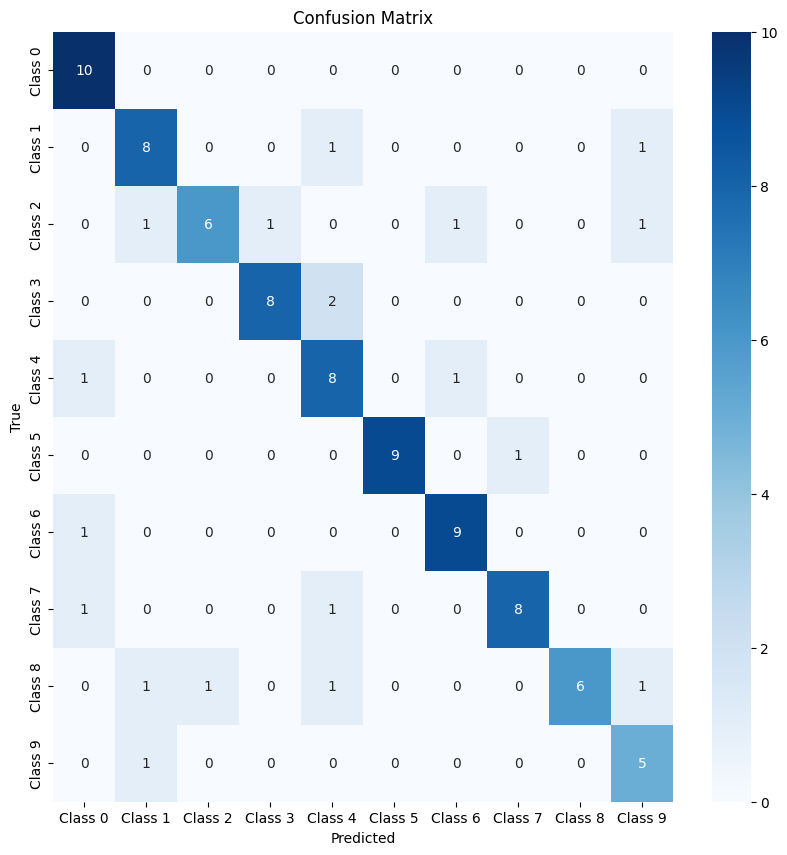

In [ ]:
import numpy as np
import torch
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터셋 로드
dataset = load_dataset('csv', data_files='/content/drive/MyDrive/Colab Notebooks/cwe file/MSR+julite+Div_final_test.csv')['train']

# 모델 로드
model_codebert = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/model/codebert(nofunc)")
model_graphcodebert = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/model/graphcodebert(nofunc)")
model_unixcoder = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/model/unixcoder(nofunc)")

# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base-mlm")

# 데이터 토크나이징 및 포맷 설정
def tokenize_function(examples):
    return tokenizer(examples['code'], truncation=True, padding="max_length", max_length=512)
encoded_dataset = dataset.map(tokenize_function, batched=True)
encoded_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# DataLoader 설정
data_loader = DataLoader(encoded_dataset, batch_size=16, drop_last=True)

# 앙상블 예측 및 레이블 수집
def soft_voting_ensemble(models, data_loader):
    softmax = torch.nn.Softmax(dim=1)
    total_probs = None
    true_labels = []
    predictions_list = []

    for batch in tqdm(data_loader, desc="Processing batches"):
        true_labels.extend(batch['labels'].numpy())
        batch_probs = None
        for model in models:
            model.eval()
            with torch.no_grad():
                outputs = model(**{k: v.to(model.device) for k, v in batch.items()})
                probs = softmax(outputs.logits)
                if batch_probs is None:
                    batch_probs = probs
                else:
                    batch_probs += probs
        batch_probs /= len(models)
        batch_predictions = torch.argmax(batch_probs, dim=1)
        predictions_list.extend(batch_predictions.cpu().numpy())

    return true_labels, predictions_list

# 모델들의 예측 수행
models = [model_codebert, model_graphcodebert, model_unixcoder]
true_labels, predicted_labels = soft_voting_ensemble(models, data_loader)

# 성능 평가 및 결과 시각화
class_names = [f'Class {i}' for i in range(10)]
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:")
print(report)

# 혼동 행렬 시각화
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import pandas as pd
df_test = pd.DataFrame(dataset)
print(df_test['CWE ID'].value_counts())


CWE ID
safe       10
CWE-119    10
CWE-20     10
CWE-125    10
CWE-787    10
CWE-415    10
CWE-399    10
CWE-416    10
CWE-476    10
CWE-190    10
Name: count, dtype: int64


In [ ]:
import re
# 모델 및 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base-mlm")
models = {
    "codebert": AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/model/codebert(nofunc)"),
    "graphcodebert": AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/model/graphcodebert(nofunc)"),
    "unixcoder": AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Notebooks/model/unixcoder(nofunc)")
}
# 예측 함수
def predict_class(input_code, models, tokenizer):
    # 입력 코드 토크나이징
    inputs = tokenizer(input_code, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # 모든 모델의 예측을 소프트맥스 확률로 합산
    sum_probs = None
    for model in models.values():
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=-1)
            sum_probs = probs if sum_probs is None else sum_probs + probs

    # 평균 확률 계산
    avg_probs = sum_probs / len(models)

    # 가장 높은 확률을 가진 클래스 선택
    predicted_class = torch.argmax(avg_probs, dim=-1).item()
    return predicted_class

def preprocess2(code_text):
  # 주석 제거
  code_text = re.sub(r'//.*?\n', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'/\*.*?\*/', '', code_text, flags=re.MULTILINE)
  code_text = re.sub(r'^#define\s+<.*?>\s*\n', '', code_text, flags=re.MULTILINE)
  code_text = re.sub(r'#include .*?\n', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'#include "*.*?\n', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'#define .*?\n', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'#undef\s+\w+', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'#if\s+\w+', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'#else\s+\w+', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'#elif\s+\w+', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'#endif', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'[\t ]+', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'\n\s*\n', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'\n', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'return*.*?;', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'return;', '', code_text, flags=re.DOTALL)
  code_text = re.sub(r'\b([a-zA-Z_]\w*)\s+([a-zA-Z_]\w*)\s*\(([^)]*)\)\s*{', r"void func(\3){", code_text, flags=re.DOTALL)

  # 코드 내의 공백 및 줄 바꿈 제거
  code_text = re.sub(r'\s+', ' ', code_text)

  return code_text



# 입력 코드 예시
input_code = """
#define JAN 1
#define FEB 2
#define MAR 3

short getMonthlySales(int month) {...}

float calculateRevenueForQuarter(short quarterSold) {...}

int determineFirstQuarterRevenue() {

// Variable for sales revenue for the quarter
float quarterRevenue = 0.0f;

short JanSold = getMonthlySales(JAN); /* Get sales in January */
short FebSold = getMonthlySales(FEB); /* Get sales in February */
short MarSold = getMonthlySales(MAR); /* Get sales in March */

// Calculate quarterly total
short quarterSold = JanSold + FebSold + MarSold;

// Calculate the total revenue for the quarter
quarterRevenue = calculateRevenueForQuarter(quarterSold);

saveFirstQuarterRevenue(quarterRevenue);

return 0;
}
"""
predicted_class_label = {
    0: "안전한 코드입니다.",
    1: "CWE-119 취약점\nImproper Restriction of Operations within the Bounds of a Memory Buffer",
    2: "CWE-20 취약점\nImproper Input Validation",
    3: "CWE-125 취약점\nOut-of-bounds Read",
    4: "CWE-787 취약점\nOut-of-bounds Write",
    5: "CWE-415 취약점\nDouble Free",
    6: "CWE-399 취약점\nResource Management Errors",
    7: "CWE-416 취약점\nUse after Free",
    8: "CWE-476 취약점\nNULL Pointer Dereference",
    9: "CWE-190 취약점\nInteger Overflow or Wraparound"
}
preprocess_text = preprocess2(input_code)

# 클래스 예측 실행
predicted_label = predict_class(preprocess_text, models, tokenizer)
predicted_class_label_text = predicted_class_label[predicted_label]
print(f"The predicted CWE ID is: Class {predicted_class_label_text}")

The predicted CWE ID is: Class CWE-787 취약점
Out-of-bounds Write
